# Conditional Deep Convolutional Generative Adversarial Networks

Implement conditional GAN as mentioned in [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) paper.

We will use DCGAN architecture and modify for taking conditional input labels.


### Let's start by imports


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip "/content/drive/MyDrive/GBC/Friends/Capstone_Project/Fashion/Data/segImagesNew.zip" -d "/content/drive/MyDrive/GBC/Friends/Capstone_Project/Fashion/Data"

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import random
import torchvision.utils as vutils

% matplotlib inline

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
# use cuda if available
DEVICE = torch.device("cuda" if torch.cuda.is_available()
                      else "cpu")
print(f"Using {DEVICE} backend")

DATASET_NAME = "FASHION"  #@param {type:"string"}
# batch size for training models 
# Change multiple of 16 only, else modify below code
BATCH_SIZE = 10  #@param {type:"integer"}
IMG_SIZE = 68  #@param {type:"integer"}

Using cuda backend


## Data Loading


In [ ]:
import os
from torch.utils.data import Dataset

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


class FashionDataset(Dataset):
    def __init__(self, json_data, root_dir, segments_dir, image_size, gen_img_sz):

        self.gen_img_sz = gen_img_sz
        self.meta_data = json_data
        self.root_dir = root_dir
        self.segments_dir = segments_dir
        self.transformGen = torchvision.transforms.Compose(
            [torchvision.transforms.Resize(size=(gen_img_sz, gen_img_sz)), torchvision.transforms.ToTensor(),
             transforms.Normalize([0.5], [0.5])])
        self.transformDis = torchvision.transforms.Compose(
            [torchvision.transforms.Resize(size=(image_size, image_size)), torchvision.transforms.ToTensor(),
             transforms.Normalize([0.5], [0.5])])

    def __len__(self):
        return len(self.meta_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        filename = list(self.meta_data[idx].keys())[0]
        # img_name = os.path.join(self.root_dir, filename)
        img_name = self.root_dir + '/' + filename
        image = Image.open(img_name).convert('RGB')

        gen_img = torch.randn(4, self.gen_img_sz, self.gen_img_sz)
        labels = []
        for img in self.meta_data[idx][filename]:
            # segImage = Image.open(os.path.join(self.segments_dir,img['segImage']))
            segImage = Image.open(self.segments_dir + '/' + img['segImage'])
            gen_img = gen_img + self.transformGen(segImage)
            labels.append(img['class'])

        sample = {'image': self.transformDis(image), 'inputImage': gen_img}

        return sample, self.get_lables(labels)

    def get_lables(self, labels):
        index = torch.tensor(labels)
        labels = torch.zeros(1, 13).index_fill_(1, index, 1)
        return labels.view(-1, 13)

In [ ]:
root_dir = "/content/drive/MyDrive/GBC/Friends/Capstone_Project/Fashion/Data/train"
seg_dir = "/content/drive/MyDrive/GBC/Friends/Capstone_Project/Fashion/Data/segImages"

f = open("/content/drive/MyDrive/GBC/Friends/Capstone_Project/Fashion/Data/metadata_train.json")
j_file = json.load(f)
f.close()

# train_data = FashionDataset(j_file[:50000], root_dir, seg_dir, 64 , 64)
train_data = FashionDataset(j_file[:1000], root_dir, seg_dir, 68, 13)

dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

In [ ]:
sam, lbl = train_data[2]

In [ ]:
lbl

tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

## Discriminator Model ( D )

Discriminator is a binary classification model, which predicts if given image is generated one or taken from training data.

Discriminator model will take a image and a class label. We will reshape class label to shape (batch_size, num_labels, 28, 28) and channel corresponding to image labels will have all ones and other all zeros.

In [ ]:
class Discriminator(nn.Module):
    """ D(x) """

    def __init__(self):
        # initalize super module
        super(Discriminator, self).__init__()

        self.linear_y = nn.Sequential(nn.Linear(13, 1024),
                                      nn.ReLU(),
                                      nn.Linear(1024, 3 * 68 * 68),
                                      nn.Sigmoid()
                                      )

        self.linear_xy = nn.Sequential(nn.Linear(100, 1),
                                       nn.Sigmoid()
                                       )

        # creating layer for image input , input size : (batch_size, 3, 64, 64)
        self.layer_x = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32,
                                               kernel_size=4, stride=2, padding=1, bias=False),
                                     # out size : (batch_size, 32, 32, 32)
                                     nn.LeakyReLU(0.2, inplace=True),
                                     # out size : (batch_size, 32, 32, 32)
                                     )

        # creating layer for label input, input size : (batch_size, 13, 64, 64)
        self.layer_y = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32,
                                               kernel_size=4, stride=2, padding=1, bias=False),
                                     # out size : (batch_size, 32, 32, 32)
                                     nn.LeakyReLU(0.2, inplace=True),
                                     # out size : (batch_size, 32, 32, 32)
                                     )

        # layer for concat of image layer and label layer, input size : (batch_size, 64, 32, 32)
        self.layer_xy = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64,
                                                kernel_size=4, stride=2, padding=1, bias=False),
                                      # out size : (batch_size, 128, 7, 7)
                                      nn.BatchNorm2d(64),
                                      # out size : (batch_size, 128, 7, 7)
                                      nn.LeakyReLU(0.2, inplace=True),
                                      # out size : (batch_size, 128, 7, 7)
                                      nn.Conv2d(in_channels=64, out_channels=32,
                                                kernel_size=3, stride=2, padding=0, bias=False),
                                      # out size : (batch_size, 256, 3, 3)
                                      nn.BatchNorm2d(32),
                                      # out size : (batch_size, 256, 3, 3)
                                      nn.LeakyReLU(0.2, inplace=True),

                                      nn.Conv2d(in_channels=32, out_channels=8,
                                                kernel_size=3, stride=2, padding=0, bias=False),
                                      # out size : (batch_size, 256, 3, 3)
                                      nn.BatchNorm2d(8),
                                      # out size : (batch_size, 256, 3, 3)
                                      nn.LeakyReLU(0.2, inplace=True),

                                      #  # out size : (batch_size, 256, 3, 3)
                                      #  # Notice in below layer, we are using out channels as 1, we don't need to use Linear layer
                                      #  # Same is recommended in DCGAN paper also
                                      nn.Conv2d(in_channels=8, out_channels=1,
                                                kernel_size=3, stride=3, padding=0, bias=False),

                                      #  # out size : (batch_size, 1, 1, 1)
                                      #  # sigmoid layer to convert in [0,1] range

                                      nn.Sigmoid()
                                      )

    def forward(self, x, y):
        y = self.linear_y(y)
        y = y.view(x.shape[0], x.shape[1], x.shape[2], x.shape[3])

        # size of x : (batch_size, 1, 64, 64)
        x = self.layer_x(x)

        # print("Y: ", x.shape)
        # size of x : (batch_size, 32, 32, 32)

        # size of y : (batch_size, 13, 64, 64)
        y = self.layer_y(y)
        # print("y: ", y.shape)
        # # size of y : (batch_size, 32, 32, 32)

        # concat image layer and label layer output
        xy = torch.cat([x, y], dim=1)
        # size of xy : (batch_size, 64, 32, 32)
        xy = self.layer_xy(xy)
        # print("xy: ", xy.shape)
        # # size of xy : (batch_size, 1, 1, 1)
        xy = xy.view(xy.shape[0], -1)
        # # size of xy : (batch_size, 1)
        # xy = self.linear_xy(xy)
        return xy

In [ ]:
# Create the Discriminator
netD = Discriminator().to(DEVICE)
print(netD)

Discriminator(
  (linear_y): Sequential(
    (0): Linear(in_features=13, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=13872, bias=True)
    (3): Sigmoid()
  )
  (linear_xy): Sequential(
    (0): Linear(in_features=100, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (layer_x): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer_y): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer_xy): Sequential(
    (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): BatchNorm2d(

### Testing NetD

In [ ]:
input_x = torch.randn(1, 3, 68, 68).to(DEVICE)
input_y = torch.randn(1, 1, 13).view(-1, 13).to(DEVICE)
out_xy = netD(input_x, input_y)

In [ ]:
[1, 1132096]
[1, 139392]
out_xy.shape

torch.Size([1, 1])

In [ ]:
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(m(input), target)
output.backward()

In [ ]:
m(input), target

(tensor([0.4124, 0.7190, 0.1609], grad_fn=<SigmoidBackward0>),
 tensor([0., 0., 0.]))

## Generator Model ( G )

Aim of the generator is to fool the discriminator model. Generator will take random noise ( latent vector) z and label for which image need to be generated. Label will be passed as onehot encoding.







In [ ]:
from torch.nn.modules.activation import Softmax
from torch.nn.modules import linear


class Generator(nn.Module):
    """ G(z) """

    def __init__(self, input_size=100):
        # initalize super module
        super(Generator, self).__init__()

        # embedded layer for y(conditional input)
        self.linear_y = nn.Sequential(nn.Linear(689, 507),
                                      nn.LeakyReLU(),

                                      self.layer_xy = nn.Sequential(
            nn.ConvTranspose2d(in_channels=3, out_channels=2, kernel_size=5,
                               stride=2, padding=0, bias=False),
            nn.BatchNorm2d(2),
            nn.LeakyReLU(True),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(in_channels=2, out_channels=2, kernel_size=5,
                               stride=2, padding=0, bias=False),
            nn.BatchNorm2d(2),
            nn.LeakyReLU(True),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(in_channels=2, out_channels=2, kernel_size=5,
                               stride=1, padding=0, bias=False),
            nn.BatchNorm2d(2),
            nn.LeakyReLU(True),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(in_channels=2, out_channels=3, kernel_size=4,
                               stride=1, padding=0, bias=False),
            nn.Tanh()
        )

        def forward(self, x, y):
            b_sz = x.shape[0]
            x = x.flatten()
            y = y.flatten()

            xy = torch.cat([x, y], dim=-1).view(b_sz, 1, -1)
            xy = self.linear_y(xy)

            xy = self.layer_xy(xy.view(b_sz, 3, 13, 13))
            # print(xy.shape)
            # xy = self.linear_xy(xy.view(b_sz,-1, 1870 * 1870))
            return xy

In [ ]:
# Create the Generator
netG = Generator().to(DEVICE)
print(netG)

Generator(
  (linear_y): Sequential(
    (0): Linear(in_features=689, out_features=507, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer_xy): Sequential(
    (0): ConvTranspose2d(3, 2, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): ConvTranspose2d(2, 2, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (5): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): ConvTranspose2d(2, 2, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (9): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): ConvTranspose2d(2, 3, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (13): Tanh(

## Testing netG

In [ ]:
# input_x = torch.randn(2, 4, 64, 64).view(2, -1, 4*64*64).to(DEVICE)
input_x = torch.randn(2, 4, 13, 13).to(DEVICE)
input_y = torch.randn(2, 1, 1, 13).view(-1, 13).to(DEVICE)
out_xy = netG(input_x, input_y)


In [ ]:
out_xy.shape


torch.Size([2, 3, 68, 68])

## Weight Initalization 
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02.

In [ ]:
# custom weights initialization
def weights_init(net):
    classname = net.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(net.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(net.weight.data, 1.0, 0.02)
        nn.init.constant_(net.bias.data, 0)

In [ ]:
# randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)
netG.apply(weights_init)

Generator(
  (linear_y): Sequential(
    (0): Linear(in_features=689, out_features=507, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer_xy): Sequential(
    (0): ConvTranspose2d(3, 2, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): ConvTranspose2d(2, 2, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (5): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): ConvTranspose2d(2, 2, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (9): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): ConvTranspose2d(2, 3, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (13): Tanh(

## Model Training



*   Value of beta1 hyperparameter in Adam optimizer has huge impact on stability of generator and DCGAN paper recommend 0.5 value.
*   Recommended learning rate for Adam is 0.0002.

In [ ]:
# number of training epochs
NUM_EPOCH = 100  #@param {type:"integer"}
# number of discriminator steps for each generator step
Ksteps = 1  #@param {type:"integer"}
# learning rate of adam
# DCGAN recommend 0.0002 lr
Adam_lr = 0.0002  #@param {type:"number"}
# DCGAN recommend 0.5
Adam_beta1 = 0.5  #@param {type:"number"}

In [ ]:
# We calculate Binary cross entropy loss
criterion = nn.BCELoss()
# Adam optimizer for generator 
optimizerG = torch.optim.Adam(netG.parameters(), lr=Adam_lr, betas=(Adam_beta1, 0.999))
# Adam optimizer for discriminator 
optimizerD = torch.optim.Adam(netD.parameters(), lr=Adam_lr, betas=(Adam_beta1, 0.999))

In [ ]:
# labels for training images x for Discriminator training
labels_real = torch.ones((BATCH_SIZE, 1)).to(DEVICE)
# labels for generated images G(z) for Discriminator training
labels_fake = torch.zeros((BATCH_SIZE, 1)).to(DEVICE)
# Fix noise for testing generator and visualization
z_test = torch.randn(68, 68).to(DEVICE)

In [ ]:
sample, lbl = train_data[200]
test_Gy = lbl.to(DEVICE)
z_test = torch.randn(3, 13, 13, device=DEVICE)
z_test = sample['inputImage'].to(DEVICE)

In [ ]:
test_Gy

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], device='cuda:0')

## Training

In [ ]:
# List of values, which will be used for plotting purpose
D_losses = []
G_losses = []
Dx_values = []
DGz_values = []
img_list = []
# number of training steps done on discriminator 
step = 0
for epoch in range(NUM_EPOCH):
    epoch_D_losses = []
    epoch_G_losses = []
    epoch_Dx = []
    epoch_DGz = []
    # iterate through data loader generator object
    for i, data in enumerate(dataloader, 0):
        images, y_labels = data
        step += 1
        ############################
        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # images will be send to gpu, if cuda available
        x = images['image'].to(DEVICE)

        D_y = y_labels.to(DEVICE)

        # forward pass D(x)
        x_preds = netD(x, D_y)

        # calculate loss log(D(x))
        D_x_loss = criterion(x_preds, labels_real)

        # create latent vector z from normal distribution
        z = images['inputImage'].to(DEVICE)
        G_y = y_labels.to(DEVICE)

        # generate image
        fake_image = netG(z, G_y)
        # calculate D(G(z)), fake or not
        z_preds = netD(fake_image.detach(), G_y)

        # loss log(1 - D(G(z)))
        D_z_loss = criterion(z_preds, labels_fake)

        # total loss = log(D(x)) + log(1 - D(G(z)))
        D_loss = D_x_loss + D_z_loss

        # save values for plots
        epoch_D_losses.append(D_loss.item())
        epoch_Dx.append(x_preds.mean().item())

        # zero accumalted grads
        netD.zero_grad()
        # do backward pass
        D_loss.backward()
        # update discriminator model
        optimizerD.step()

        ############################
        # Update G network: maximize log(D(G(z)))
        ###########################

        # if Ksteps of Discriminator training are done, update generator
        if step % Ksteps == 0:
            # As we done one step of discriminator, again calculate D(G(z))
            z_out = netD(fake_image, G_y)

            # loss log(D(G(z)))
            G_loss = criterion(z_out, labels_real)
            # G_loss = -torch.mean(z_out)

            # save values for plots
            epoch_DGz.append(z_out.mean().item())
            epoch_G_losses.append(G_loss)

            # zero accumalted grads
            netG.zero_grad()
            # do backward pass
            G_loss.backward()
            # update generator model
            optimizerG.step()
    else:
        # calculate average value for one epoch
        D_losses.append(sum(epoch_D_losses) / len(epoch_D_losses))
        G_losses.append(sum(epoch_G_losses) / len(epoch_G_losses))
        Dx_values.append(sum(epoch_Dx) / len(epoch_Dx))
        DGz_values.append(sum(epoch_DGz) / len(epoch_DGz))

        print(f" Epoch {epoch + 1}/{NUM_EPOCH} Discriminator Loss {D_losses[-1]:.3f} Generator Loss {G_losses[-1]:.3f}"
              + f" D(x) {Dx_values[-1]:.3f} D(G(x)) {DGz_values[-1]:.3f}")

        # Generating images after each epoch and saving
        # set generator to evaluation mode
        netG.eval()

        if (step % 50 == 0) and (i == len(dataloader) - 1):
            with torch.no_grad():
                fake = netG(z_test.view(1, 4, 13, 13), test_Gy.view(1, 1, 13)).cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        netG.train()

 Epoch 1/100 Discriminator Loss 0.005 Generator Loss 7.560 D(x) 0.998 D(G(x)) 0.002
 Epoch 2/100 Discriminator Loss 0.049 Generator Loss 7.463 D(x) 0.993 D(G(x)) 0.007
 Epoch 3/100 Discriminator Loss 0.021 Generator Loss 8.252 D(x) 0.995 D(G(x)) 0.004
 Epoch 4/100 Discriminator Loss 0.030 Generator Loss 7.982 D(x) 0.994 D(G(x)) 0.003
 Epoch 5/100 Discriminator Loss 0.013 Generator Loss 8.508 D(x) 0.997 D(G(x)) 0.002
 Epoch 6/100 Discriminator Loss 0.022 Generator Loss 8.353 D(x) 0.996 D(G(x)) 0.003
 Epoch 7/100 Discriminator Loss 0.005 Generator Loss 8.688 D(x) 0.998 D(G(x)) 0.002
 Epoch 8/100 Discriminator Loss 0.003 Generator Loss 8.145 D(x) 0.999 D(G(x)) 0.001
 Epoch 9/100 Discriminator Loss 0.016 Generator Loss 9.085 D(x) 0.996 D(G(x)) 0.002
 Epoch 10/100 Discriminator Loss 0.002 Generator Loss 8.822 D(x) 0.999 D(G(x)) 0.001
 Epoch 11/100 Discriminator Loss 0.027 Generator Loss 8.300 D(x) 0.996 D(G(x)) 0.002
 Epoch 12/100 Discriminator Loss 0.004 Generator Loss 8.395 D(x) 0.998 D(G

## Results

After 20 epoch training, we are able to generate quite good images.

## Save model

In [ ]:
# torch.save(netG.state_dict(), '/content/drive/MyDrive/GBC/Friends/Capstone_Project/Fashion/netG.pt')
# torch.save(netD.state_dict(), '/content/drive/MyDrive/GBC/Friends/Capstone_Project/Fashion/netD.pt')

## Load and test Model

In [ ]:
model = Generator().to(DEVICE)
model.load_state_dict(torch.load('/content/drive/MyDrive/GBC/Friends/Capstone_Project/Fashion/netG.pt'))
model.eval()

Generator(
  (linear_y): Sequential(
    (0): Linear(in_features=689, out_features=507, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer_xy): Sequential(
    (0): ConvTranspose2d(3, 2, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): ConvTranspose2d(2, 2, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (5): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): ConvTranspose2d(2, 2, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (9): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): ConvTranspose2d(2, 3, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (13): Tanh(

In [ ]:
i = np.random.randint(1000, size=1)[0]
sample, lbl = train_data[i]
test_Gy = lbl.to(DEVICE)
z_test = sample['inputImage'].to(DEVICE)

fake2 = model(z_test.view(1, 4, 13, 13), test_Gy.view(1, 1, 13)).cpu()
img = vutils.make_grid(fake2, padding=2, normalize=True)

## plot generated Image

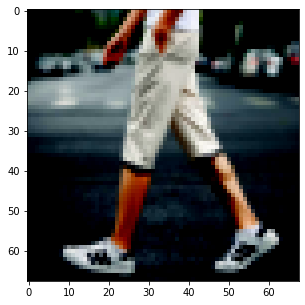

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(np.transpose(img, (1, 2, 0)))



### Plot for Discriminator and Generator loss over the epochs

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Discriminator and Generator loss during Training")
# plot Discriminator and generator loss
plt.plot(D_losses, label="D Loss")
plt.plot(G_losses, label="G Loss")
# get plot axis
ax = plt.gca()
# remove right and top spine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# add labels and create legend
plt.xlabel("num_epochs")
plt.legend()
plt.show()